In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
from numpy import loadtxt, corrcoef, delete, array, concatenate, vstack, ones, triu, where
from numpy.linalg import lstsq
from scipy.stats import f, t

In [2]:
BIG_CORRELATION = 0.9
SIGNIFICANCE = 0.05
MAX_POW = 2

In [3]:
def remove_worst(seq):
    return delete(seq.flatten(), array([((seq - item)**2).sum() for item in seq]).argmax())
    # return seq

In [4]:
dataset = loadtxt('lab1.csv', skiprows=1, delimiter=',')
y = remove_worst(dataset[:, 0])
xs = array([remove_worst(dataset[:, i]) for i in range(1, dataset.shape[1])])
regression_coefficients = []

In [5]:
worst_pairs = where(triu(abs(corrcoef(xs)), 1) > BIG_CORRELATION)
correlations = abs(corrcoef(y, xs))[0][1:]
worst = [i if correlations[i] < correlations[j] else j for i, j in zip(*worst_pairs)]
xs = delete(xs, worst, axis=0)

In [6]:
# accum = [array([y]), xs]
accum = [xs]
last = xs
for i in range(MAX_POW-1):
    last = [last[i]*xs[i:] for i in range(xs.shape[0])]
    accum += last
sequences = concatenate(accum)

In [7]:
def get_residuum(y, regressors, coefficients):
    return y - array([c * r for c, r in zip(regressors, coefficients)]).sum(axis=0)

In [8]:
def get_coeffs(y, regressors, coefficients, sequences):
    residuum = get_residuum(y, regressors, coefficients)
    A = vstack([[residuum], sequences])
    best = abs(corrcoef(A)[0][1:]).argmax()
    regressor = sequences[best]
    sequences = delete(sequences, best, axis=0)
    regressors += [regressor]
    coefficients = lstsq(array(regressors).T, y)[0]
    new_residuum = get_residuum(y, regressors, coefficients)
    S = (residuum**2).sum(), (new_residuum**2).sum()
    F = (regressor.size - len(regressors)) * (S[0] - S[1]) / S[1]
    print('F', F)
    return regressors, coefficients, sequences, F

In [9]:
new_sequences = sequences.copy()
coefficients = [y.mean()]
regressors = [ones(sequences[0].size)]
all_coefficients = [coefficients[0]]
all_regressors = [regressors[0]]
for i in range(min(sequences.shape[0], y.size)):
    regressors, coefficients, new_sequences, F = get_coeffs(y, regressors, coefficients, new_sequences)
    all_coefficients.append(coefficients)
    all_regressors.append(regressors[-1])
    #print('Step {:0>2}: tail probability is {:05.2f}% (>={:05.2f}% needed)'.format(
    #    i, 100 * (1 - f.cdf(F, 1, regressors[0].size - i - 1)), 100 * (1 - SIGNIFICANCE)))
    print('Step', i)
    # if f.cdf(F, 1, regressors[0].size - len(regressors) + 1) < SIGNIFICANCE:
    if F < 4.2:
        print('FINISH')
        break
else:
    print('Best solution not found')

F 16.2704872732
Step 0
F 18.4145428523
Step 1
F 207.709162906
Step 2
F 2.73588113143
Step 3
FINISH


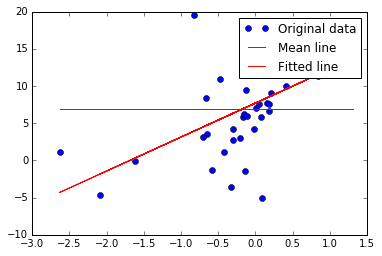

In [10]:
a, b = all_coefficients[1]
plt.plot(all_regressors[1], y, 'o', label='Original data')
plt.plot(all_regressors[1], all_coefficients[0] * all_regressors[0], label='Mean line')
plt.plot(all_regressors[1], a * all_regressors[0] + b * all_regressors[1], label='Fitted line')
plt.legend()
plt.show()

In [11]:
student = array([s for s in all_coefficients[-1] / (((array(all_regressors)**2)/(len(all_regressors)-1))**.5).sum(axis=1)])
student
#all_coefficients[-1] / (((array(all_regressors)**2)/(len(all_regressors)-1))**.5)
((array(all_regressors).sum(axis=1)**2)/(len(all_regressors)-1))**.5

array([ 19.5      ,   3.1900975,   1.6025   ,   4.148282 ,   1.4187745])

In [12]:
residuum = get_residuum(y, all_regressors, all_coefficients[-1])
last_regressors = delete(all_regressors, 4, axis=0)
last_coefficients = lstsq(array(last_regressors).T, y)[0]
new_residuum = get_residuum(y, last_regressors, last_coefficients)

In [13]:
array([t.cdf(s, len(last_regressors[0]) - len(last_regressors)) for s in last_coefficients / (((array(last_regressors)**2)/len(last_regressors))**.5).sum(axis=1)]).max()

0.90014009536405459

In [15]:
S = (residuum**2).sum(), (new_residuum**2).sum()
F = (last_regressors.size - len(last_regressors)) * (S[0] - S[1]) / S[1]
F

-11.320102286098273